In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Dropout, Flatten
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.src.utils import pad_sequences
from sklearn.model_selection import train_test_split
import json
from custom_preprocessor import preprocess

# Get data
Pandas is used to get the data from the project directory.
The data is a .csv file, that has been created by book texts and prepared to be listed in the file word-by-word.

In [7]:
df = pd.read_csv('./data/dataset_germanic.csv')
df = df.sample(frac=1.0, random_state=12)
df.head()

,Word,Language
32859,knows a tiny knows a tiny knows a tiny knows a,English
20523,kontinent recht lange kontinent recht lange,German
19012,von einer von einer von einer von einer von,German
76845,lugn ur en lugn ur en lugn ur en lugn ur en lugn,Swedish
21638,betreffenden oberbehorden berufung betreffenden,German


# Prepare data
Divide the data into X and y. X is input and y is the desired output.
One-Hot Encode it, so the language is categorical. This is done with Pandas.

In [8]:
# Getting X - the input values
X = df.iloc[:, :-1]
X.loc[:, 'Word'] = X['Word'].astype(str)
tokenizer = Tokenizer(char_level=True) # Used for turning the words into numbers
tokenizer.fit_on_texts(X['Word'].tolist()) # Giving Tokenizer the data it needs to learn how to encode the words
X_sequences = tokenizer.texts_to_sequences(X['Word'].tolist()) # Now the words are encoded into sequences
input_dim = max(len(seq) for seq in X_sequences)
print(f"Input dimension: {input_dim}")
X = pad_sequences(
    X_sequences, 
    maxlen=input_dim, 
    padding='post'
) # Making all input values be of same length
print(f"Rows: {len(X)}")

# Getting y - the output values
y_df = pd.get_dummies(df.iloc[:, -1:])
y = y_df.values
print(f"Amount of languages to identify: {len(y[1])}")

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_train = X_train.astype('float32')

Input dimension: 49
Rows: 86454
Amount of languages to identify: 6


In [9]:
model = Sequential()
model.add(Conv1D(input_dim, 2, activation='relu'))  # Convolutional layer
model.add(LSTM(32, return_sequences=True))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(len(y[1]), activation='softmax'))
adam = optimizers.Adam(learning_rate=0.01)
model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [10]:
history = model.fit(X_train.astype('float32'), y_train.astype('float32'), validation_data=(X_val, y_val), epochs=60, batch_size=2048,verbose=1)

Epoch 1/60
34/34 [==============================] - 6s 157ms/step - loss: 1.8622 - accuracy: 0.1759 - val_loss: 1.7818 - val_accuracy: 0.2018
Epoch 2/60
34/34 [==============================] - 5s 155ms/step - loss: 1.7704 - accuracy: 0.2232 - val_loss: 1.7475 - val_accuracy: 0.2475
Epoch 3/60
34/34 [==============================] - 5s 159ms/step - loss: 1.7159 - accuracy: 0.2730 - val_loss: 1.6782 - val_accuracy: 0.3025
Epoch 4/60
34/34 [==============================] - 6s 162ms/step - loss: 1.6562 - accuracy: 0.3150 - val_loss: 1.6155 - val_accuracy: 0.3390
Epoch 5/60
34/34 [==============================] - 5s 150ms/step - loss: 1.6063 - accuracy: 0.3448 - val_loss: 1.5606 - val_accuracy: 0.3674
Epoch 6/60
34/34 [==============================] - 5s 152ms/step - loss: 1.5581 - accuracy: 0.3684 - val_loss: 1.5080 - val_accuracy: 0.3914
Epoch 7/60
34/34 [==============================] - 6s 163ms/step - loss: 1.5189 - accuracy: 0.3874 - val_loss: 1.4771 - val_accuracy: 0.4001
Epoch 

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

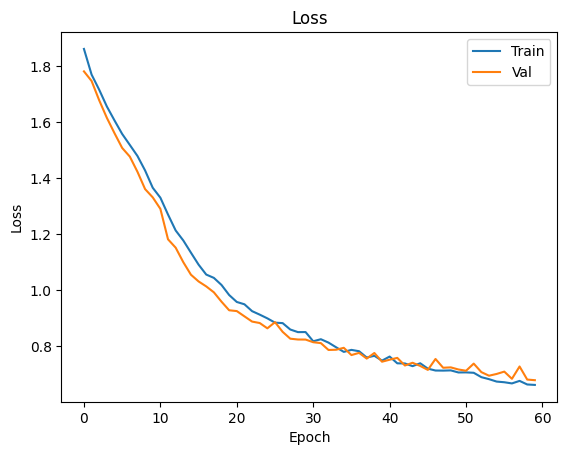

In [11]:
%matplotlib inline
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title("Loss")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Loss evaluation

Seeing how the model's loss changes by the epoch

Text(0.5, 0, 'Epoch')

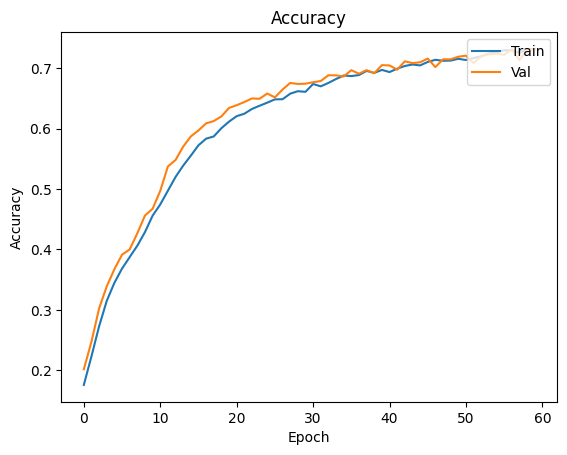

In [12]:
%matplotlib inline
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title("Accuracy")
plt.legend(['Train', 'Val'], loc='upper right')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Prediction

In [13]:
prediction_word = "hvordan går det"
print(f"Text before preprocessing: {prediction_word}")
prediction_word = preprocess(prediction_word)
print(f"Text after preprocessing: {prediction_word}")
prediction_word = tokenizer.texts_to_sequences([prediction_word])
prediction_word = pad_sequences(prediction_word, maxlen=input_dim)
prediction = model.predict([prediction_word])
output_probabilities = np.array(prediction)
result = {}
class_labels = np.unique(y_df.columns)
for index, prediction in enumerate(output_probabilities[0]):
    result.update({class_labels[index]: round(prediction * 100, 1)})

# Print keys and values of the result dictionary
for key, value in result.items():
    print(f"{key}: {value}")

Text before preprocessing: hvordan går det
Text after preprocessing: hvordan gar det hvordan gar det hvordan gar det
1/1 [==============================] - 0s 167ms/step
Language_Danish: 23.0
Language_Dutch: 0.0
Language_English: 0.0
Language_German: 0.0
Language_Norwegian: 18.2
Language_Swedish: 58.7


# Save model
Here a model can be loaded

In [14]:
model.save('./models/model_germanic.keras')
tokenizer_json = tokenizer.to_json()
with open('./tokenizer_configs/tokenizer_config_germanic.json', 'w') as config_file:
    config_file.write(json.dumps(tokenizer_json, ensure_ascii=False))

# Load model
Here a model can be loaded

In [ ]:
model = load_model('./models/model_germanic.keras')